# Prediction Model

# 1. Data and preprocessing

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,target,weight,sensecoh,ageatfdr,gn_2.0,household_1.0,psydsord_1.0,chrodse_1.0,prhealth_1.0,psydist_1.0,...,ecactiv_2.0,ecactiv_3.0,ecactiv_4.0,BDI3_0.0,BDI3_1.0,BDI3_2.0,phyact_1.0,phyact_2.0,phyact_3.0,phyact_4.0
0,0.0,1.086293,65.0,17.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.086293,73.0,19.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.086293,59.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.086293,64.0,17.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.945237,58.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
 # Kannabis use
data['target'].value_counts(normalize= True)

0.0    0.513158
1.0    0.486842
Name: target, dtype: float64

In [4]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
X, y = data.iloc[:, 1:], data.iloc[:, 0]


#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter(y)}")

Class counts after resampling Counter({0.0: 195, 1.0: 185})


In [5]:
print('Dimension of train data: ', X_train.shape)
print('Dimension of test data: ', X_test.shape)

Dimension of train data:  (266, 28)
Dimension of test data:  (114, 28)


In [6]:
# necessary for XGBoost 
# removed - from categoric variable names (age bins)
#X_train.columns[X_train.columns.str.contains("[\[\]<]")]
X_train.columns = X_train.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

# 2. Model Building with Cross Validation

I will use the main classification models under the hood of sklearn. I will first analyze based on original data set and then apply the same methods on new data set.

In [7]:
# Load libraries
# plot
import matplotlib.pyplot as plt
from chart_studio.plotly import plot, iplot
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import matplotlib.font_manager

#models                   
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier



In [8]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression(max_iter= 1000)))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('ADA'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('Bagging'   , BaggingClassifier()))
    basedModels.append(('XGBoost'   , XGBClassifier(eval_metric='mlogloss')))



    
    return basedModels

In [9]:
def BasedLine2(X_train, y_train, models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [10]:
class PlotBoxR(object):

    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [11]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train, models)
PlotBoxR().PlotResult(names,results)

LR: 0.579915 (0.074887)
LDA: 0.568519 (0.077516)
KNN: 0.473504 (0.122041)
CART: 0.534615 (0.071787)
NB: 0.586752 (0.073149)
SVM: 0.500285 (0.039987)
ADA: 0.530627 (0.089839)
GBM: 0.531054 (0.068802)
RF: 0.564387 (0.066357)
ET: 0.553276 (0.075427)
Bagging: 0.541738 (0.082227)
XGBoost: 0.527778 (0.106621)


In [12]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [13]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

,Model,Score
0,LR,0.5799
1,LDA,0.5685
2,KNN,0.4735
3,CART,0.5346
4,NB,0.5868
5,SVM,0.5003
6,ADA,0.5306
7,GBM,0.5311
8,RF,0.5644
9,ET,0.5533


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler =='robust':
        scaler = RobustScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))
    pipelines.append((nameOfScaler+'Bagging', Pipeline([('Scaler', scaler),('Bagging', BaggingClassifier())])))
    pipelines.append((nameOfScaler+'XGBoost', Pipeline([('Scaler', scaler),('Bagging', XGBClassifier(eval_metric='mlogloss'))])))

    return pipelines 

In [15]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train, models)
PlotBoxR().PlotResult(names,results)
scaledScoreStandard = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

standardLR: 0.565100 (0.091603)
standardLDA: 0.568519 (0.077516)
standardKNN: 0.534473 (0.060362)
standardCART: 0.546154 (0.087437)
standardNB: 0.586752 (0.073149)
standardSVM: 0.568091 (0.070018)
standardAB: 0.530627 (0.089839)
standardGBM: 0.531054 (0.068802)
standardRF: 0.575783 (0.090025)
standardET: 0.541880 (0.064949)
standardBagging: 0.527208 (0.116479)
standardXGBoost: 0.527778 (0.106621)


,Model,Score,Model,Score
0,LR,0.5799,standardLR,0.5651
1,LDA,0.5685,standardLDA,0.5685
2,KNN,0.4735,standardKNN,0.5345
3,CART,0.5346,standardCART,0.5462
4,NB,0.5868,standardNB,0.5868
5,SVM,0.5003,standardSVM,0.5681
6,ADA,0.5306,standardAB,0.5306
7,GBM,0.5311,standardGBM,0.5311
8,RF,0.5644,standardRF,0.5758
9,ET,0.5533,standardET,0.5419


In [16]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax], axis=1)
compareModels

minmaxLR: 0.576211 (0.080244)
minmaxLDA: 0.568519 (0.077516)
minmaxKNN: 0.553276 (0.058748)
minmaxCART: 0.515670 (0.071660)
minmaxNB: 0.586752 (0.073149)
minmaxSVM: 0.587037 (0.080661)
minmaxAB: 0.530627 (0.089839)
minmaxGBM: 0.530912 (0.091845)
minmaxRF: 0.568803 (0.078093)
minmaxET: 0.556838 (0.080217)
minmaxBagging: 0.519373 (0.077567)
minmaxXGBoost: 0.527778 (0.106621)


,Model,Score,Model,Score,Model,Score
0,LR,0.5799,standardLR,0.5651,minmaxLR,0.5762
1,LDA,0.5685,standardLDA,0.5685,minmaxLDA,0.5685
2,KNN,0.4735,standardKNN,0.5345,minmaxKNN,0.5533
3,CART,0.5346,standardCART,0.5462,minmaxCART,0.5157
4,NB,0.5868,standardNB,0.5868,minmaxNB,0.5868
5,SVM,0.5003,standardSVM,0.5681,minmaxSVM,0.5870
6,ADA,0.5306,standardAB,0.5306,minmaxAB,0.5306
7,GBM,0.5311,standardGBM,0.5311,minmaxGBM,0.5309
8,RF,0.5644,standardRF,0.5758,minmaxRF,0.5688
9,ET,0.5533,standardET,0.5419,minmaxET,0.5568


In [17]:
models = GetScaledModel('robust')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

scaledScoreRobost = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                          scaledScoreStandard,
                          scaledScoreMinMax,
                          scaledScoreRobost], axis=1)
compareModels

robustLR: 0.580057 (0.086527)
robustLDA: 0.568519 (0.077516)
robustKNN: 0.583333 (0.079191)
robustCART: 0.538746 (0.098323)
robustNB: 0.586752 (0.073149)
robustSVM: 0.576353 (0.109316)
robustAB: 0.530627 (0.089839)
robustGBM: 0.523362 (0.069223)
robustRF: 0.582906 (0.079215)
robustET: 0.564387 (0.101775)
robustBagging: 0.568661 (0.082552)
robustXGBoost: 0.527778 (0.106621)


,Model,Score,Model,Score,Model,Score,Model,Score
0,LR,0.5799,standardLR,0.5651,minmaxLR,0.5762,robustLR,0.5801
1,LDA,0.5685,standardLDA,0.5685,minmaxLDA,0.5685,robustLDA,0.5685
2,KNN,0.4735,standardKNN,0.5345,minmaxKNN,0.5533,robustKNN,0.5833
3,CART,0.5346,standardCART,0.5462,minmaxCART,0.5157,robustCART,0.5387
4,NB,0.5868,standardNB,0.5868,minmaxNB,0.5868,robustNB,0.5868
5,SVM,0.5003,standardSVM,0.5681,minmaxSVM,0.5870,robustSVM,0.5764
6,ADA,0.5306,standardAB,0.5306,minmaxAB,0.5306,robustAB,0.5306
7,GBM,0.5311,standardGBM,0.5311,minmaxGBM,0.5309,robustGBM,0.5234
8,RF,0.5644,standardRF,0.5758,minmaxRF,0.5688,robustRF,0.5829
9,ET,0.5533,standardET,0.5419,minmaxET,0.5568,robustET,0.5644


In [18]:
# final stage for scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


scaler_final = MinMaxScaler()
X_train_std = scaler_final.fit_transform(X_train)
X_test_std = scaler_final.transform(X_test)

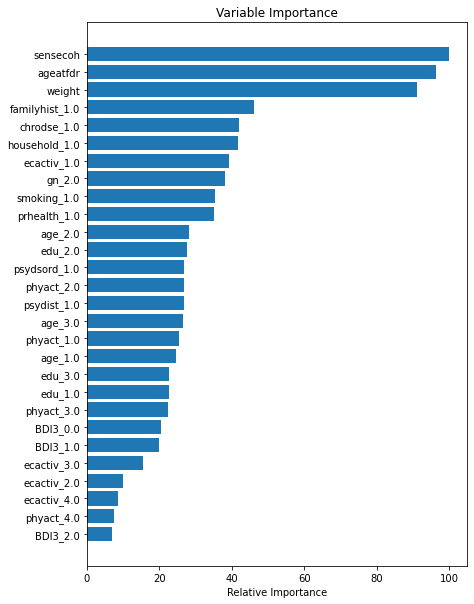

In [19]:
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=42)

clf.fit(X_train_std, y_train)

# #############################################################################
from matplotlib import pyplot as plt

# Plot feature importance
fig = plt.figure(figsize=(15,10))


feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) #boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('variable_importance.png')
plt.show()


# 3. Cross-Validation and Hyper Parameters Tuning

In [20]:
def plot_matrics(y_pred):    
    
    #y_pred = pipeline.predict(X_test)
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

    from sklearn.metrics import roc_auc_score
    print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

    print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


    #Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix
    from io import BytesIO #neded for plot
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


    plt.xlabel('true label')
    plt.ylabel('predicted label');

    plt.savefig("Confusion.jpg")
    # Save SVG in a fake file object.
    f = BytesIO()
    plt.savefig(f, format="svg")

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [22]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelFeatures(self):
        best_model,_ = self.RandomSearch()
        best_estimator = best_model.best_estimator_
        best_features = best_estimator.feature_importances_
        return best_features
        

    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred
    



In [23]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train, model, hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))


        return best_model,best_model.best_params_
   
    def BestModelFeatures(self):
        best_model,_ = self.GridSearch()
        best_estimator = best_model.best_estimator_
        best_features = best_estimator.feature_importances_
        return best_features

        
    
    def BestModelPridict(self,X_test):
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [24]:
matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle') # selecting the style sheet

In [25]:
def feature_importance_plot(feature_importance):   
    # Apa style
    matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle') # selecting the style sheet

    # Plot feature importance
    fig = plt.figure(figsize=(15,10))

    #feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    #feature_importance = 100.0 * (feature_importance)


    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx]) #boston.feature_names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.savefig("img/vip.jpg")
    

    plt.show()

## Logistic Regression

C : Regularization value, the more, the stronger the regularization(double).


RegularizationType: Can be either "L2" or “L1”. Default is “L2”.

In [26]:
# model
model = LogisticRegression(max_iter= 1000)
# Create regularization penalty space
penalty = [ 'l2'] # 'l1',

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



In [27]:
LR_RandSearch = RandomSearch(X_train_std,y_train, model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test_std)

Best: 0.571795 using {'C': 0.0774678314811883, 'penalty': 'l2'}


In [28]:
def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" #first cast decimal as str
    #     print(prc) #str format output is {:.3f}
        return float(prc.format(f_val))

In [29]:
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_LR).mean(),7))

prediction on test set is: 0.5263158


Accuracy: 0.5263
Precision: 0.5264
Recall: 0.5263
F1 Score: 0.5257
Cohen Kappa Score: 0.0526
Matthews Corrcoef: 0.0528
roc_auc_score: 0.5263157894736842
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.52      0.54        61
         1.0       0.49      0.53      0.51        53

    accuracy                           0.53       114
   macro avg       0.53      0.53      0.53       114
weighted avg       0.53      0.53      0.53       114

Confusion Matrix:
 [[32 25]
 [29 28]]


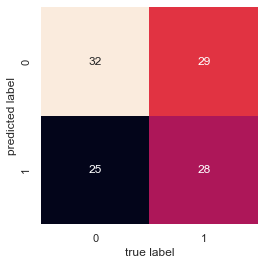

In [30]:
plot_matrics(Prediction_LR)

## KNN

n_neighbors: Number of neighbors to use by default for k_neighbors queries



In [31]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [32]:
KNN_GridSearch = GridSearch(X_train_std,y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_KNN).mean(),7))

Best: 0.572365 using {'n_neighbors': 19}
prediction on test set is: 0.5789474


Accuracy: 0.5789
Precision: 0.584
Recall: 0.5789
F1 Score: 0.5725
Cohen Kappa Score: 0.1579
Matthews Corrcoef: 0.1629
roc_auc_score: 0.5789473684210527
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.46      0.60      0.52        43
         1.0       0.70      0.56      0.62        71

    accuracy                           0.58       114
   macro avg       0.58      0.58      0.57       114
weighted avg       0.61      0.58      0.59       114

Confusion Matrix:
 [[26 31]
 [17 40]]


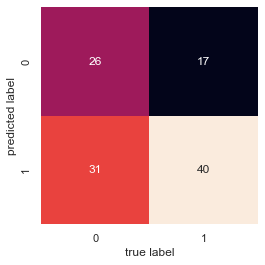

In [33]:
plot_matrics(Prediction_KNN)

## SVC
C: The Penalty parameter C of the error term.

Kernel: Kernel type could be linear, poly, rbf or sigmoid.

In [34]:
#c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
c_values = [50, 100, 200]


kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()

In [35]:
SVC_GridSearch = GridSearch(X_train_std,y_train,model_SVC,param_grid)
Prediction_SVC = SVC_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_SVC).mean(),7))

Best: 0.593305 using {'C': 50, 'kernel': 'sigmoid'}
prediction on test set is: 0.5175439


Accuracy: 0.5175
Precision: 0.5178
Recall: 0.5175
F1 Score: 0.5157
Cohen Kappa Score: 0.0351
Matthews Corrcoef: 0.0354
roc_auc_score: 0.5175438596491229
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.46      0.52      0.49        50
         1.0       0.58      0.52      0.55        64

    accuracy                           0.52       114
   macro avg       0.52      0.52      0.52       114
weighted avg       0.53      0.52      0.52       114

Confusion Matrix:
 [[26 31]
 [24 33]]


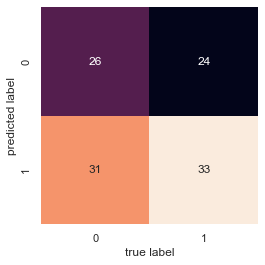

In [36]:
plot_matrics(Prediction_SVC)

## Decision Tree

max_depth: Maximum depth of the tree (double).

row_subsample: Proportion of observations to consider (double).

max_features: Proportion of columns (features) to consider in each level (double).

In [37]:
from scipy.stats import randint
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

In [38]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [39]:
model_CART = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train_std,y_train,model_CART,param_grid)
Prediction_CART = CART_RandSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_CART).mean(),7))

Best: 0.616667 using {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2}
prediction on test set is: 0.4824561


Accuracy: 0.4825
Precision: 0.4818
Recall: 0.4825
F1 Score: 0.4776
Cohen Kappa Score: -0.0351
Matthews Corrcoef: -0.0358
roc_auc_score: 0.4824561403508772
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.49      0.53        68
         1.0       0.39      0.48      0.43        46

    accuracy                           0.48       114
   macro avg       0.48      0.48      0.48       114
weighted avg       0.50      0.48      0.49       114

Confusion Matrix:
 [[33 24]
 [35 22]]


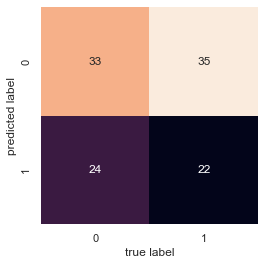

In [40]:
plot_matrics(Prediction_CART)

Best: 0.624786 using {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1}


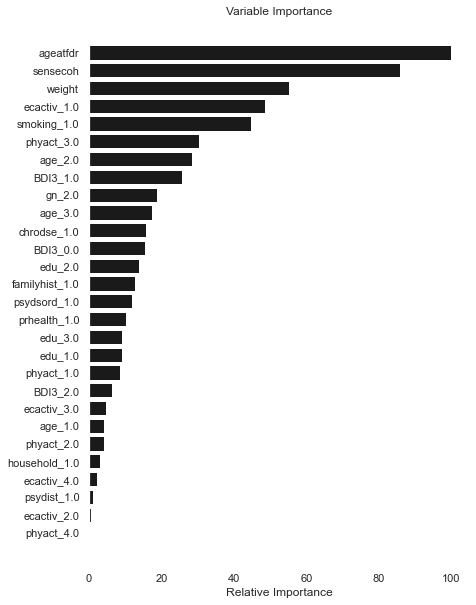

In [41]:
Cart_features = CART_RandSearch.BestModelFeatures()
feature_importance_plot(Cart_features)

## AdaBoostClassifier

learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate.

n_estimators: Number of trees to build.

In [42]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [43]:
model_Ad = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train_std ,y_train, model_Ad, param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_Ad).mean(),7))

Best: 0.628063 using {'learning_rate': 0.01, 'n_estimators': 100}
prediction on test set is: 0.5526316


Accuracy: 0.5526
Precision: 0.5652
Recall: 0.5526
F1 Score: 0.53
Cohen Kappa Score: 0.1053
Matthews Corrcoef: 0.1171
roc_auc_score: 0.5526315789473684
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.33      0.59      0.43        32
         1.0       0.77      0.54      0.63        82

    accuracy                           0.55       114
   macro avg       0.55      0.57      0.53       114
weighted avg       0.65      0.55      0.58       114

Confusion Matrix:
 [[19 38]
 [13 44]]


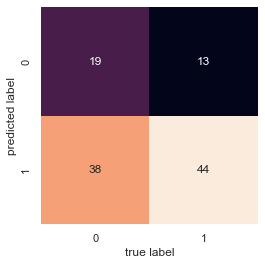

In [44]:
plot_matrics(Prediction_Ad)

Best: 0.628063 using {'learning_rate': 0.01, 'n_estimators': 100}


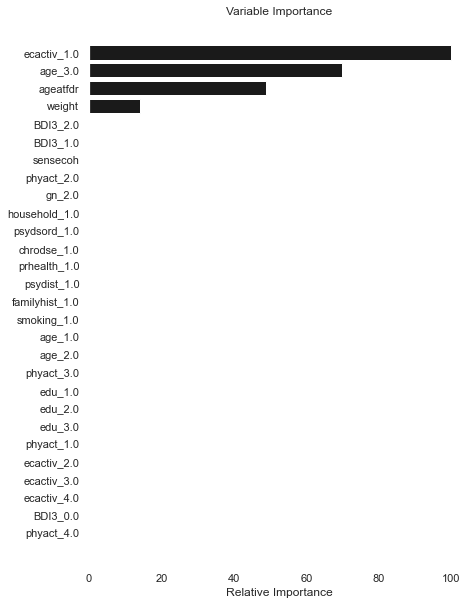

In [45]:
ADA_features = Ad_GridSearch.BestModelFeatures()
feature_importance_plot(ADA_features)

## GradientBoosting

In [46]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [47]:
model_GB = GradientBoostingClassifier()
GB_GridSearch = GridSearch(X_train_std,y_train,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_GB).mean(),7))

Best: 0.575783 using {'learning_rate': 0.05, 'n_estimators': 150}
prediction on test set is: 0.5701754


Accuracy: 0.5702
Precision: 0.5702
Recall: 0.5702
F1 Score: 0.5701
Cohen Kappa Score: 0.1404
Matthews Corrcoef: 0.1404
roc_auc_score: 0.5701754385964912
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.57      0.57        58
         1.0       0.56      0.57      0.57        56

    accuracy                           0.57       114
   macro avg       0.57      0.57      0.57       114
weighted avg       0.57      0.57      0.57       114

Confusion Matrix:
 [[33 24]
 [25 32]]


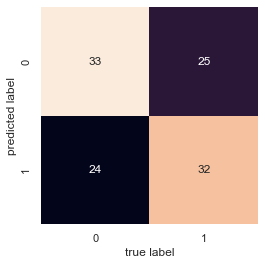

In [48]:
plot_matrics(Prediction_GB)

Best: 0.575783 using {'learning_rate': 0.05, 'n_estimators': 150}


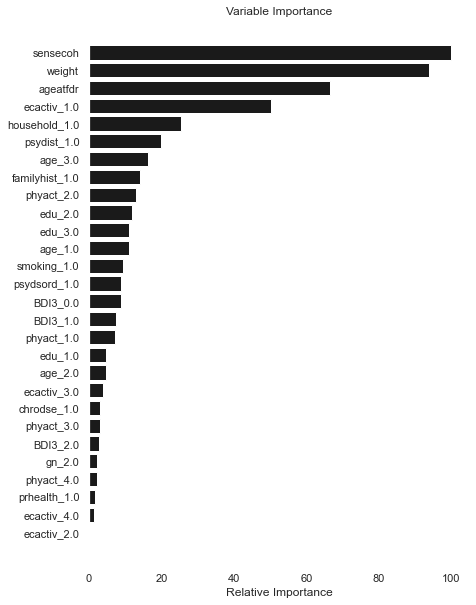

In [49]:
GB_features = GB_GridSearch.BestModelFeatures()
feature_importance_plot(GB_features)

## Extra tree

In [50]:
n_estimators= [10, 50, 100, 500, 1000]
criterion = ["gini", "entropy"]
max_depth = [ 10, 15, 20]
param_grid = dict(n_estimators=n_estimators_value,
                  criterion = criterion,
                  max_depth = max_depth  
                 )

In [51]:
model_ET = ExtraTreesClassifier()
ET_GridSearch = GridSearch(X_train_std,y_train,model_ET,param_grid)
Prediction_ET = ET_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_ET).mean(),7))

Best: 0.582621 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
prediction on test set is: 0.6052632


Accuracy: 0.6053
Precision: 0.6069
Recall: 0.6053
F1 Score: 0.6038
Cohen Kappa Score: 0.2105
Matthews Corrcoef: 0.2121
roc_auc_score: 0.605263157894737
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.59      0.63        64
         1.0       0.54      0.62      0.58        50

    accuracy                           0.61       114
   macro avg       0.61      0.61      0.60       114
weighted avg       0.61      0.61      0.61       114

Confusion Matrix:
 [[38 19]
 [26 31]]


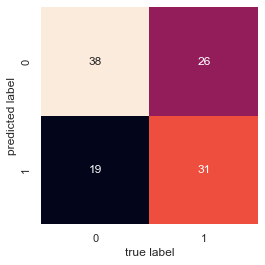

In [52]:
plot_matrics(Prediction_ET)

Best: 0.593732 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


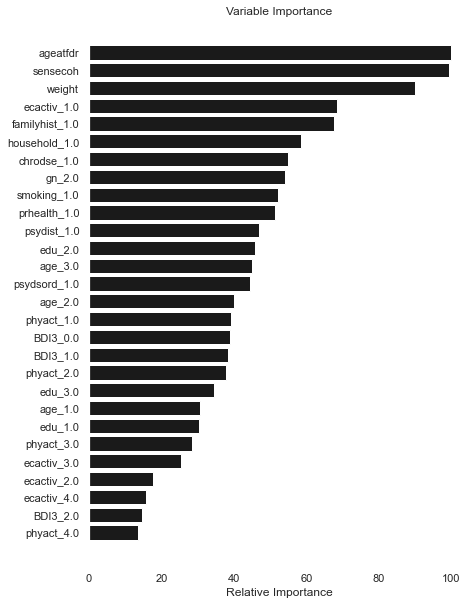

In [53]:
ET_features = ET_GridSearch.BestModelFeatures()
feature_importance_plot(ET_features)

## XGBoost

In [54]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'colsample_bytree': [0.3, 0.7]
}



In [55]:
model_XGB = XGBClassifier(eval_metric='mlogloss', use_label_encoder =False, objective= 'binary:logistic',
    nthread=4,
    seed=42)
XGB_GridSearch = GridSearch(X_train_std,y_train,model_XGB, param_grid)
Prediction_XGB = XGB_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_XGB).mean(),7))

Best: 0.619943 using {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 60}
prediction on test set is: 0.5614035


Accuracy: 0.5614
Precision: 0.5775
Recall: 0.5614
F1 Score: 0.5373
Cohen Kappa Score: 0.1228
Matthews Corrcoef: 0.138
roc_auc_score: 0.5614035087719298
		Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.61      0.43        31
           1       0.79      0.54      0.64        83

    accuracy                           0.56       114
   macro avg       0.56      0.58      0.54       114
weighted avg       0.67      0.56      0.59       114

Confusion Matrix:
 [[19 38]
 [12 45]]


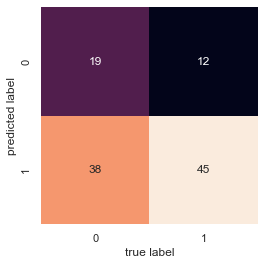

In [56]:
plot_matrics(Prediction_XGB)

Best: 0.619943 using {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 60}


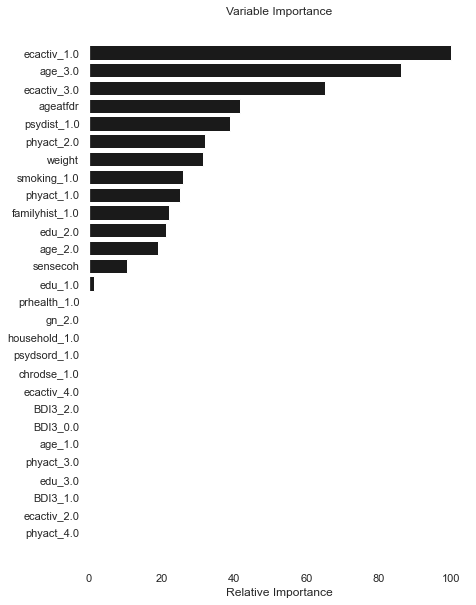

In [57]:
XGB_features = XGB_GridSearch.BestModelFeatures()
feature_importance_plot(XGB_features)

## Bagging

In [58]:

n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];



param_grid = {'n_estimators':n_estimators,
              'base_estimator__max_leaf_nodes':[10, 15],
              'base_estimator__max_depth':[4, 5, 6]
              
              
        }
dt = DecisionTreeClassifier()
final_dt = DecisionTreeClassifier(max_leaf_nodes=10, max_depth=5)                   





In [59]:
## If None, then the base estimator is a decision tree.
#model_bagging = BaggingClassifier(base_estimator= None, bootstrap_features=False)

model_bagging = BaggingClassifier(base_estimator=final_dt, random_state=1)


bagging_GridSearch = GridSearch(X_train_std,y_train,model_bagging, param_grid)
Prediction_bagging = bagging_GridSearch.BestModelPridict(X_test_std)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_bagging).mean(),7))

Best: 0.579487 using {'base_estimator__max_depth': 4, 'base_estimator__max_leaf_nodes': 15, 'n_estimators': 10}
prediction on test set is: 0.622807


Accuracy: 0.6228
Precision: 0.6228
Recall: 0.6228
F1 Score: 0.6228
Cohen Kappa Score: 0.2456
Matthews Corrcoef: 0.2457
roc_auc_score: 0.6228070175438596
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.62      0.62        56
         1.0       0.63      0.62      0.63        58

    accuracy                           0.62       114
   macro avg       0.62      0.62      0.62       114
weighted avg       0.62      0.62      0.62       114

Confusion Matrix:
 [[35 22]
 [21 36]]


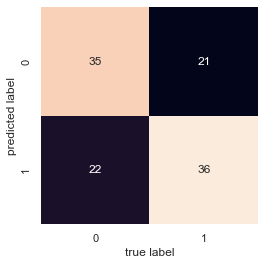

In [60]:
plot_matrics(Prediction_bagging)

## Random Forest 

In [61]:
"""
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt','log2']
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
"""

# simple
# Define Parameters
max_depth=[4, 8, 16, 20]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)



In [62]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier()
RF_GridSearch = GridSearch(X_train_std,y_train,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(X_test_std)

print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_RF).mean(),7))



Best: 0.575499 using {'max_depth': 4, 'n_estimators': 64}
prediction on test set is: 0.5789474


Accuracy: 0.5789
Precision: 0.5877
Recall: 0.5789
F1 Score: 0.5682
Cohen Kappa Score: 0.1579
Matthews Corrcoef: 0.1664
roc_auc_score: 0.5789473684210527
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.62      0.50        39
         1.0       0.74      0.56      0.64        75

    accuracy                           0.58       114
   macro avg       0.58      0.59      0.57       114
weighted avg       0.63      0.58      0.59       114

Confusion Matrix:
 [[24 33]
 [15 42]]


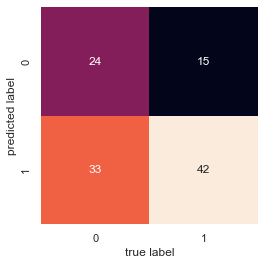

In [63]:
plot_matrics(Prediction_RF)

Best: 0.601852 using {'max_depth': 4, 'n_estimators': 64}


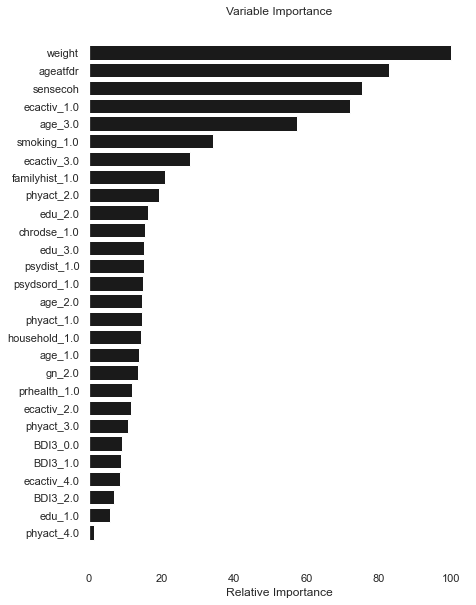

In [64]:
RF_features = RF_GridSearch.BestModelFeatures()
feature_importance_plot(RF_features)

# Ensemble Methods

## Voting Ensemble
Voting is one of the simplest ways of combining the predictions from multiple machine learning algorithms. It works by first creating two or more standalone models from your training dataset. A Voting Classifier can then be used to wrap your models and average the predictions of the sub-models when asked to make predictions for new data.

In [65]:
from sklearn.ensemble import VotingClassifier

In [66]:
#param = {'C': 0.7678243129497218, 'penalty': 'l1'}
param = {'C': 0.7678243129497218, 'penalty': 'l2'}
model1 = LogisticRegression(**param)

param = {'n_neighbors': 15}
model2 = KNeighborsClassifier(**param)

param = {'C': 1.7, 'kernel': 'linear'}
model3 = SVC(**param)

param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
model4 = DecisionTreeClassifier(**param)

param = {'learning_rate': 0.05, 'n_estimators': 150}
model5 = AdaBoostClassifier(**param)

param = {'learning_rate': 0.01, 'n_estimators': 100}
model6 = GradientBoostingClassifier(**param)

model7 = GaussianNB()

param=  {'max_depth': randint(2, 5),'min_samples_split': randint(5, 20), 'min_samples_leaf': randint(10, 20),
     'n_estimators': randint(50, 100),
     'max_features': uniform(0.6, 0.3)
    }
model8 = RandomForestClassifier()

model9 = ExtraTreesClassifier()

model10 = BaggingClassifier()

param = {'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8,'max_depth':6, 'colsample_bytree': 1, 'gamma':1}
model11 = XGBClassifier(eval_metric='mlogloss')

In [67]:
# create the sub models
estimators = [('LR',model1), ('KNN',model2), ('SVC',model3),
              ('DT',model4), ('ADa',model5), ('GB',model6),
              ('NB',model7), ('RF',model8),  ('ET',model9),
              ('Bagging',model10), ('XGB',model11)
             ]
    

In [68]:
# create the ensemble model
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X_train_std,y_train, cv=kfold)
print('Accuracy on train: ',results.mean())
ensemble_model = ensemble.fit(X_train_std,y_train)
pred = ensemble_model.predict(X_test_std)
print('Accuracy on test:' , (y_test == pred).mean())

Accuracy on train:  0.587037037037037
Accuracy on test: 0.5350877192982456


## Beyond Voting

In [69]:
def get_models():
    """Generate a library of base learners."""
    #param = {'C': 0.7678243129497218, 'penalty': 'l1'}
    param = {'C': 0.7678243129497218, 'penalty': 'l2'}
    model1 = LogisticRegression(**param)

    param = {'n_neighbors': 15}
    model2 = KNeighborsClassifier(**param)

    param = {'C': 1.7, 'kernel': 'linear', 'probability':True}
    model3 = SVC(**param)

    param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
    model4 = DecisionTreeClassifier(**param)

    param = {'learning_rate': 0.05, 'n_estimators': 150}
    model5 = AdaBoostClassifier(**param)

    param = {'learning_rate': 0.01, 'n_estimators': 100}
    model6 = GradientBoostingClassifier(**param)

    model7 = GaussianNB()

    model8 = RandomForestClassifier()

    model9 = ExtraTreesClassifier()
    model10 = BaggingClassifier()

    param = {'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8,'max_depth':6, 'colsample_bytree': 1, 'gamma':1}
    model11 = XGBClassifier(eval_metric='mlogloss')

    models = {'LR':model1, 'KNN':model2, 'SVC':model3,
              'DT':model4, 'ADa':model5, 'GB':model6,
              'NB':model7, 'RF':model8,  'ET':model9,
              'Bagging':model10, 'XGB':model11
              }

    return models

## Error Corrolation

In [70]:
def train_predict(model_list,xtrain, xtest, ytrain, ytest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [71]:
models = get_models()
P = train_predict(models,X_train_std,X_test_std,y_train,y_test)

Fitting models.
LR... done
KNN... done
SVC... done
DT... done
ADa... done
GB... done
NB... done
RF... done
ET... done
Bagging... done
XGB... done
Done.



[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (192): /tmp/.mlens_tmp_cache_iv3pnxd2
        Total size: 192
[MLENS] Removing... done.


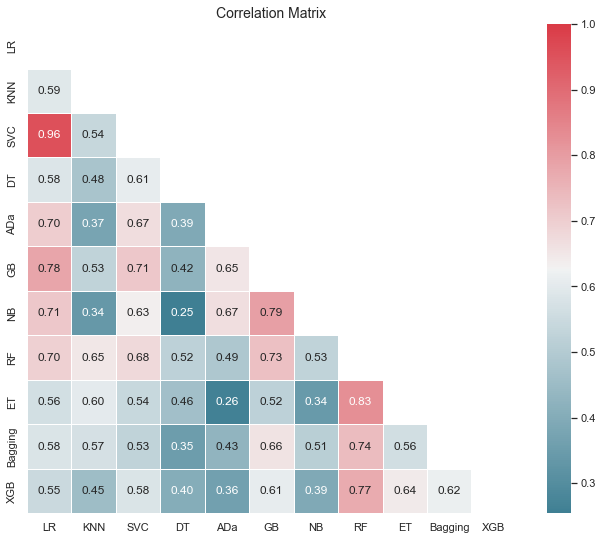

<AxesSubplot:title={'center':'Correlation Matrix'}>

In [72]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)

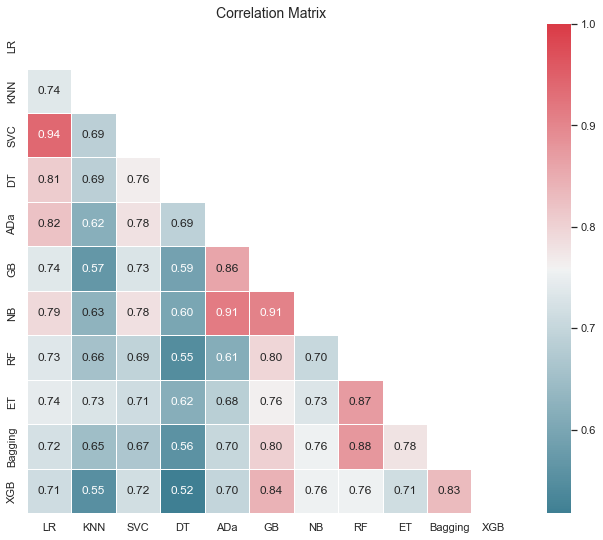

<AxesSubplot:title={'center':'Correlation Matrix'}>

In [73]:
corrmat(P.apply(lambda predic: 1*(predic >= 0.5) - y_test).corr(), inflate=False)

# Stacking

In [74]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=42
)

In [ ]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=42,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train_std, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_test_std)

# print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test_sc, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             

In [ ]:
pp = []
for p in p_sl[:, 1]:
    if p>0.5:
        pp.append(1.)
    else:
        pp.append(0.)

In [ ]:
print("\nSuper Learner Accuracy score: %.8f" % (y_test== pp).mean())


In [ ]:
# summarize base learners
print(sl.data)




# Summary

- Our results show that extratree, XGB and Random Forest models produce satisfactor results for our study design. 
- We can also test NN models but since the sample size is small, we are not exptecting a considerable improvement. 
- I also create visialization map for decision tree, if you are interested in, you can check it out. 






Reference for [codes](https://www.kaggle.com/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86/notebook)